    Use log soft max because it is numericaly more stable!

    It is worse to class a customer as good when they are bad, than it is to class a customer as bad when they are good.
    dropout value should be optimized
    

# Portfolio-Exam 

#### Inports

In [575]:
# Imports 

# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Sklearn
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn import metrics as ms
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Tensorboard
from torch.utils.tensorboard import SummaryWriter

#### Set Variables

In [576]:
random_seed = 42                     # Set random seed for reproducibility
torch.manual_seed(42)                # Set torch seed for reproducibility
torch.set_default_dtype(torch.float) # Set default tensor type to float

## Task 1 - Story

## Task 2 - The Data



|Variable Name| Role| Type| Demographic| Description| Units| Missing Values|
|---|---|---|---|---|---|---|
|Attribute1|	Feature|	Categorical|		        |Status of existing checking account| |  no|
|Attribute2|	Feature|	Integer|		            |Duration|	months|	no|
|Attribute3|	Feature|	Categorical|		        |Credit history|	|	no|
|Attribute4|	Feature|	Categorical|		        |Purpose|	|	no|
|Attribute5|	Feature|	Integer|		            |Credit amount|	|	no|
|Attribute6|	Feature|	Categorical|		        |Savings account/bonds|	|	no|
|Attribute7|	Feature|	Categorical|    Other|	Present employment since|		|no|
|Attribute8|	Feature|	Integer|		    |Installment rate in percentage of disposable income|		|no|
|Attribute9|	Feature|	Categorical|    Marital Status|	Personal status and sex|		|no|
|Attribute10|	Feature|	Categorical|		|Other debtors / guarantors|		|no|
|Attribute11|	Feature|	Integer|		|Present residence since|	|no|
|Attribute12|	Feature|	Categorical|		|Property|		|no|
|Attribute13|	Feature|	Integer|	Age	|Age    |years|	no|
|Attribute14|	Feature|	Categorical|		|Other installment plans|		|no|
|Attribute15|	Feature|    Categorical|	Other|	Housing|		|no|
|Attribute16|	Feature|	Integer|		|Number of existing credits at this bank|		|no|
|Attribute17|	Feature|	Categorical|	Occupation|	Job	|	|no|
|Attribute18|	Feature|	Integer|		|Number of people being liable to provide maintenance for| |no|
|Attribute19|	Feature|	Binary|		|Telephone|		|no|
|Attribute20|	Feature|	Binary|	Other	|foreign worker|	|no|
|class|	Target|	Binary|		|1 = Good, 2 = Bad|		|no|

In [577]:
# Load the dataset
df = pd.read_csv('data/german.data', sep=' ', header=None) 

Since the file contains no Column names, they will be added manually.
The columns are known from the file german.doc that comes with the dataset.

In [578]:
# Define column names
columns = [
    "Status_of_existing_checking_account", "Duration_in_months", "Credit_history", 
    "Purpose", "Credit_amount", "Savings_account_bonds", "Present_employment_since", 
    "Installment_rate_as_percentage_of_disposable_income", "Personal_status_and_sex", 
    "Other_debtors_guarantors", "Present_residence_since", "Property", "Age_in_years", 
    "Other_installment_plans", "Housing", "Number_of_existing_credits_at_this_bank", 
    "Job", "Number_of_people_being_liable_to_provide_maintenance_for", "Telephone", 
    "Foreign_worker", "Class"
]

In [579]:
# Assign column names to the dataframe
df.columns = columns

The categorical columns are encoded, which makes the IDA more difficult.
To overcome this, categorical columns will be mapped to the categories they represent.

In [580]:
# Define the mapping for categorical values
mappings = {
    "Status_of_existing_checking_account": {
        "A11": "< 0 DM", "A12": "0 <= ... < 200 DM", "A13": ">= 200 DM", "A14": "no checking account"
    },
    "Credit_history": {
        "A30": "no credits/all credits paid back duly", "A31": "all credits at this bank paid back duly", 
        "A32": "existing credits paid back duly till now", "A33": "delay in paying off in the past", 
        "A34": "critical account/other credits existing"
    },
    "Purpose": {
        "A40": "car (new)", "A41": "car (used)", "A42": "furniture/equipment", 
        "A43": "radio/television", "A44": "domestic appliances", "A45": "repairs", 
        "A46": "education", "A48": "retraining", "A49": "business", "A410": "others"
    },
    "Savings_account_bonds": {
        "A61": "< 100 DM", "A62": "100 <= ... < 500 DM", "A63": "500 <= ... < 1000 DM", 
        "A64": ">= 1000 DM", "A65": "unknown/ no savings account"
    },
    "Present_employment_since": {
        "A71": "unemployed", "A72": "< 1 year", "A73": "1 <= ... < 4 years", 
        "A74": "4 <= ... < 7 years", "A75": ">= 7 years"
    },
    "Personal_status_and_sex": {
        "A91": "male : divorced/separated", "A92": "female : divorced/separated/married", 
        "A93": "male : single", "A94": "male : married/widowed", "A95": "female : single"
    },
    "Other_debtors_guarantors": {
        "A101": "none", "A102": "co-applicant", "A103": "guarantor"
    },
    "Property": {
        "A121": "real estate", "A122": "building society savings agreement/life insurance", 
        "A123": "car or other", "A124": "unknown / no property"
    },
    "Other_installment_plans": {
        "A141": "bank", "A142": "stores", "A143": "none"
    },
    "Housing": {
        "A151": "rent", "A152": "own", "A153": "for free"
    },
    "Job": {
        "A171": "unemployed/ unskilled - non-resident", "A172": "unskilled - resident", 
        "A173": "skilled employee / official", "A174": "management/ self-employed/ highly qualified employee/ officer"
    },
    "Telephone": {
        "A191": "none", "A192": "yes, registered under the customer's name"
    },
    "Foreign_worker": {
        "A201": "yes", "A202": "no"
    },
    "Class": {
        1: "Good", 2: "Bad"
    }
}

# Apply the mapping to the dataframe
for column, mapping in mappings.items():
    df[column] = df[column].map(mapping)

**Dataset Citation:** <br>
Hofmann,Hans. (1994). Statlog (German Credit Data). UCI Machine Learning Repository. https://doi.org/10.24432/C5NC77.

## Task 3 - IDA

In [581]:
def calc_dist_class(data, name, binary):
    """Calculate the distribution of the classes in the dataset.
    Args:
        data (dataframe): dataset.
        name (string): name of the dataset.
        binary (bool): True if the dataset is binary, False if not.
    Returns:
        None
    """
    if binary:
        class_counts = np.bincount(data)
    else: 
        class_counts = data['Class'].value_counts()

    class_frequencies = np.array(class_counts) / len(data)
    print(f'The number of good transactions in {name} is: {class_counts.iloc[0]} and the number of bad transactions in {name} is: {class_counts.iloc[1]}.')
    print(f'The percentage of good transactions in {name} is: {class_frequencies[0]*100:.0f}% and percentage of bad transactions in {name} is: {class_frequencies[1]*100:.0f}%.')

In [582]:
def initial_data_analysis(df, name):
    """
    Gives information about the dataframe for a quick overview.
    Args:
        df (pandas.DataFrame): The dataframe to be analysed.
        name (str): The name of the dataframe.
    Returns:
        None
    """
    print(f'Initial data analysis for {name}:\n')
    print(f'Shape: {df.shape}\n')

    # Look at the distribution of the target variable
    calc_dist_class(df, name, False)

    column_name = []
    dtype = []
    count = []
    unique = []
    missing_values = []
    # Create a list of column names, data types, number of non-null values, number of unique values, and number of missing values
    for column in df.columns:
        column_name.append(column)
        dtype.append(df[column].dtype)
        count.append(df[column].count())
        unique.append(df[column].nunique())
        missing_values.append(df[column].isna().sum())

    # Create a dataframe consisting of the lists
    overview_values = pd.DataFrame({'column_name': column_name, 'dtype': dtype, 'count': count, 'unique': unique, 'missing_values': missing_values})
    display(overview_values)
    
    # Sum up all the values in missing_values to get the total number of missing values
    missing_val = sum(missing_values)
    total_cells = np.prod(df.shape)
    print(f'Sum of missing values: {missing_val}\n') 
    print(f'Percentage of null values: {missing_val/total_cells*100:.2f}%\n') 

    # Check for duplicates 
    if df.duplicated().sum() == 0:
        print('No duplicates found.\n')
    else:
        print('Duplicates found.\n')

    # Display the first 5 rows of the dataframe
    print('Head:')
    display(df.head())

    # Get descriptive statistics for the numerical columns
    print('Descriptive statistics for numerical columns:')
    display(df.describe().round(2))
    print(' ') # Do a linebreak

In [583]:
# Perform initial data analysis
initial_data_analysis(df, 'German Credit Data')

Initial data analysis for German Credit Data:

Shape: (1000, 21)

The number of good transactions in German Credit Data is: 700 and the number of bad transactions in German Credit Data is: 300.
The percentage of good transactions in German Credit Data is: 70% and percentage of bad transactions in German Credit Data is: 30%.


,column_name,dtype,count,unique,missing_values
0,Status_of_existing_checking_account,object,1000,4,0
1,Duration_in_months,int64,1000,33,0
2,Credit_history,object,1000,5,0
3,Purpose,object,1000,10,0
4,Credit_amount,int64,1000,921,0
5,Savings_account_bonds,object,1000,5,0
6,Present_employment_since,object,1000,5,0
7,Installment_rate_as_percentage_of_disposable_i...,int64,1000,4,0
8,Personal_status_and_sex,object,1000,4,0
9,Other_debtors_guarantors,object,1000,3,0


Sum of missing values: 0

Percentage of null values: 0.00%

No duplicates found.

Head:


,Status_of_existing_checking_account,Duration_in_months,Credit_history,Purpose,Credit_amount,Savings_account_bonds,Present_employment_since,Installment_rate_as_percentage_of_disposable_income,Personal_status_and_sex,Other_debtors_guarantors,...,Property,Age_in_years,Other_installment_plans,Housing,Number_of_existing_credits_at_this_bank,Job,Number_of_people_being_liable_to_provide_maintenance_for,Telephone,Foreign_worker,Class
0,< 0 DM,6,critical account/other credits existing,radio/television,1169,unknown/ no savings account,>= 7 years,4,male : single,none,...,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customer's name",yes,Good
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,radio/television,5951,< 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee / official,1,none,yes,Bad
2,no checking account,12,critical account/other credits existing,education,2096,< 100 DM,4 <= ... < 7 years,2,male : single,none,...,real estate,49,none,own,1,unskilled - resident,2,none,yes,Good
3,< 0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,< 100 DM,4 <= ... < 7 years,2,male : single,guarantor,...,building society savings agreement/life insurance,45,none,for free,1,skilled employee / official,2,none,yes,Good
4,< 0 DM,24,delay in paying off in the past,car (new),4870,< 100 DM,1 <= ... < 4 years,3,male : single,none,...,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes,Bad


Descriptive statistics for numerical columns:


,Duration_in_months,Credit_amount,Installment_rate_as_percentage_of_disposable_income,Present_residence_since,Age_in_years,Number_of_existing_credits_at_this_bank,Number_of_people_being_liable_to_provide_maintenance_for
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,20.90,3271.26,2.97,2.84,35.55,1.41,1.16
std,12.06,2822.74,1.12,1.10,11.38,0.58,0.36
min,4.00,250.00,1.00,1.00,19.00,1.00,1.00
25%,12.00,1365.50,2.00,2.00,27.00,1.00,1.00
50%,18.00,2319.50,3.00,3.00,33.00,1.00,1.00
75%,24.00,3972.25,4.00,4.00,42.00,2.00,1.00
max,72.00,18424.00,4.00,4.00,75.00,4.00,2.00


#### Visualize the distribution of the Classes

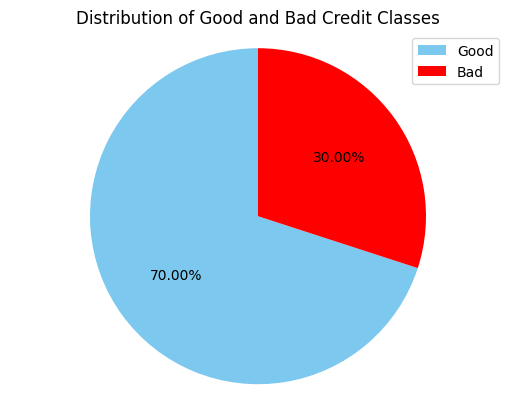

In [584]:
# Count the number of samples in each class
class_counts = df['Class'].value_counts()

# Define colors for the pie slices
colors = ['#7cc8ee', 'red']

# Create a pie chart
fig, ax = plt.subplots()
pie = ax.pie(class_counts, labels=['Good', 'Bad'], colors=colors, autopct='%1.2f%%', startangle=90)
for label in pie[1]: # Set the label color to white so it's invisible
    label.set_color('white')
ax.legend(pie[0], ['Good', 'Bad'], loc='upper right') # Add a legend
ax.set_title('Distribution of Good and Bad Credit Classes') # Add a title
ax.axis('equal')
plt.show()

#### Visualize the distribution of the credit amount

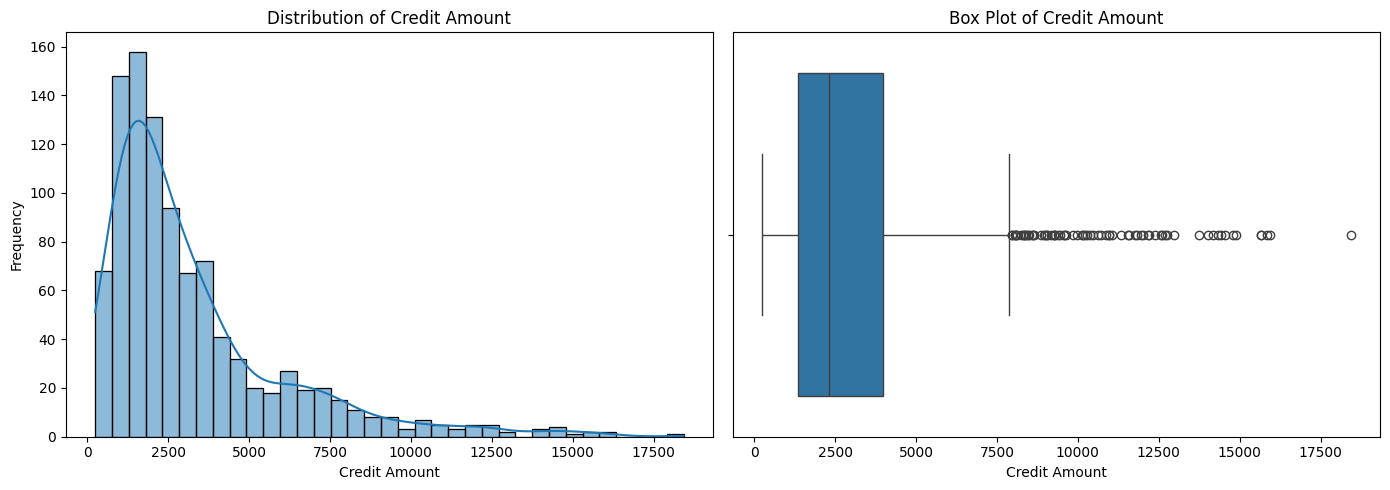

In [585]:
# Set up the matplotlib figure
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of Credit Amount
sns.histplot(df['Credit_amount'], kde=True, ax=axs[0])
axs[0].set_title('Distribution of Credit Amount')
axs[0].set_xlabel('Credit Amount')
axs[0].set_ylabel('Frequency')

# Box plot of Credit Amount
sns.boxplot(x=df['Credit_amount'], ax=axs[1])
axs[1].set_title('Box Plot of Credit Amount')
axs[1].set_xlabel('Credit Amount')

plt.tight_layout()
plt.show()

#### Visualize the distribution of the duration of the credit

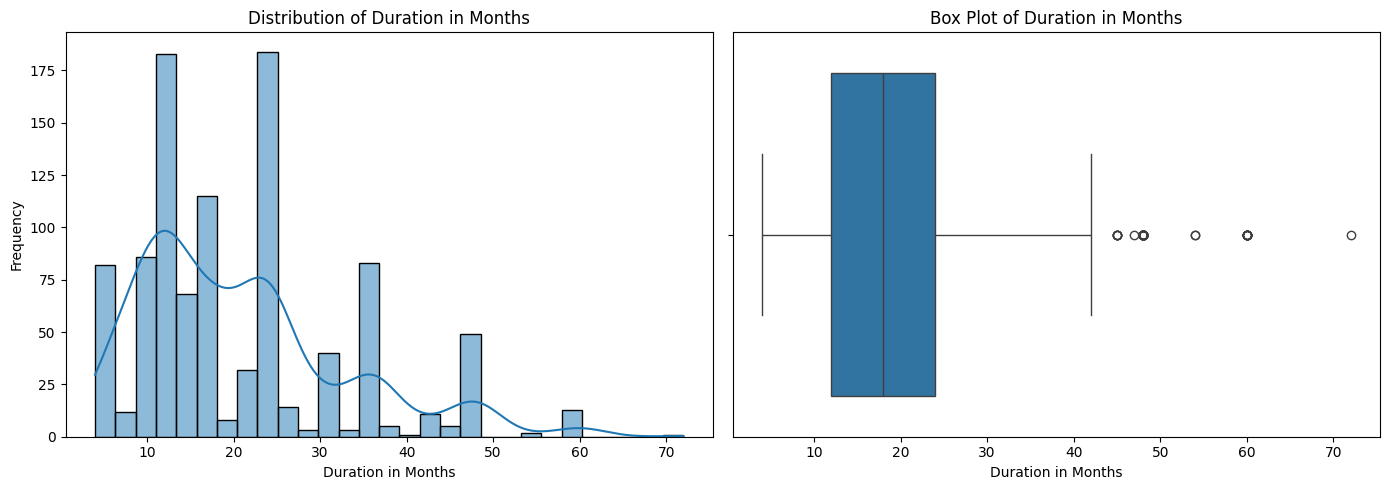

In [586]:
# Set up the matplotlib figure
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of Duration in Months
sns.histplot(df['Duration_in_months'], kde=True, ax=axs[0])
axs[0].set_title('Distribution of Duration in Months')
axs[0].set_xlabel('Duration in Months')
axs[0].set_ylabel('Frequency')

# Box plot of Duration in Months
sns.boxplot(x=df['Duration_in_months'], ax=axs[1])
axs[1].set_title('Box Plot of Duration in Months')
axs[1].set_xlabel('Duration in Months')

plt.tight_layout()
plt.show()


#### Look at the distribution of the amount of credit of each class

In [587]:
display(df.groupby('Class')['Credit_amount'].describe().round(2))

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
Bad,300.0,3938.13,3535.82,433.0,1352.5,2574.5,5141.50,18424.0
Good,700.0,2985.46,2401.47,250.0,1375.5,2244.0,3634.75,15857.0


#### Look at the distribution of the duration in months of each class

In [588]:
display(df.groupby('Class')['Duration_in_months'].describe().round(2))

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
Bad,300.0,24.86,13.28,6.0,12.0,24.0,36.0,72.0
Good,700.0,19.21,11.08,4.0,12.0,18.0,24.0,60.0


## Task 4 - EDA, Preprocessing

#### Problematic Features

Columns that are problematic because of potential discrimination and bias concerns:

- **Age_in_years:** Age is a sensitive attribute and could lead to age discrimination. On the other hand the age is a legitimate factor to consider in credit risk assessment, because high age could lead to higher risk of death before the credit is paid back. Therefore, this column will be kept in the dataset.

- **Foreign_worker:** This column indicates whether the applicant is a foreign worker, which could lead to discrimination based on nationality. Therfore this column will be removed from the dataset.

- **Personal_status_and_sex:** This column combines personal status and sex, which could introduce gender bias into the model. Therfore this column will be removed from the dataset.

In [589]:
# Drop columns because of discriminatory concerns
df.drop(columns=["Personal_status_and_sex", "Foreign_worker"], inplace=True)
df.shape

(1000, 19)

After removing Personal_status and Foreign_worker contains 19 columns.

#### Encoding Categorical Variables
Dummy variables will be created for the categorical variables.

In [590]:
# Encoding categorical variables using one-hot encoding
df_encoded = pd.get_dummies(df, drop_first=True) 
df_encoded.shape

(1000, 45)

After dummy encoding the categorical columns, the dataset contains 45 features.

#### Separating the Target Variable

In [591]:
# Separating features and target variable
X = df_encoded.drop('Class_Good', axis=1)  # 'Class_Good' is the target variable after encoding
y = df_encoded['Class_Good']

#### Split the Data

In [592]:
# Split data into train (42%), validation (18%), and test (40%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=random_seed)
# From the remaining 60%, the validation set should be 18% of the total, therefore the validation set size need to be set to 0.18/0.6 = 0.3!!!!
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.30, shuffle=True, random_state=random_seed)

#### Scale the data

In [593]:
x_scaler = MinMaxScaler()
# No y_scaler needed since it is a classification problem and not a regression problem 

In [594]:
# Fit and transform the features
x_scaler.fit(X_train_full)
X_train_sc = x_scaler.transform(X_train)
X_val_sc = x_scaler.transform(X_val)
X_test_sc = x_scaler.transform(X_test)

Ensure that the data is split into the wanted proportions.

In [595]:
# Calculate the size of test, train and val sets and calculate percentage of each
test_size = len(X_test_sc)
train_size = len(X_train_sc)
val_size = len(X_val_sc)

test_size_percent = test_size / (test_size + train_size + val_size) * 100
train_size_percent = train_size / (test_size + train_size + val_size) * 100
val_size_percent = val_size / (test_size + train_size + val_size) * 100

# Print the size of test, train and val sets and percentage of each
print("Test set size: ", test_size)
print("Train set size: ", train_size)
print("Validation set size: ", val_size)
print(f"Test set size percentage: {test_size_percent} %")
print(f"Train set size percentage: {train_size_percent} %")
print(f"Validation set size percentage: {val_size_percent} %")

Test set size:  400
Train set size:  420
Validation set size:  180
Test set size percentage: 40.0 %
Train set size percentage: 42.0 %
Validation set size percentage: 18.0 %


#### Dealing with Imbalanced Classes

In [596]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_sc_smote, y_train_smote = smote.fit_resample(X_train_sc, y_train)

In [597]:
# Ceck if the distribution of the classes is now balanced
y_train_smote.value_counts()

Class_Good
True     292
False    292
Name: count, dtype: int64

    do not forget to present and summarize properties/distributions of the result.

#### Create Tensors

In [598]:
# Convert to PyTorch tensors
X_train_sc_smote_tens = torch.tensor(X_train_sc_smote, dtype=torch.float32)
y_train_smote_tens = torch.tensor(y_train_smote.values, dtype=torch.long)
X_val_sc_tens = torch.tensor(X_val_sc, dtype=torch.float32)
y_val_tens = torch.tensor(y_val.values, dtype=torch.long)
X_test_sc_tens = torch.tensor(X_test_sc, dtype=torch.float32)
y_test_tens = torch.tensor(y_test.values, dtype=torch.long)

Ensure that the tensors are created with the correct dimensions.

In [599]:
# Check the sizes of the tensors
print("Train set size:", X_train_sc_smote_tens.size(), y_train_smote_tens.size())
print("Validation set size:", X_val_sc_tens.size(), y_val_tens.size())
print("Test set size:", X_test_sc_tens.size(), y_test_tens.size())

Train set size: torch.Size([584, 44]) torch.Size([584])
Validation set size: torch.Size([180, 44]) torch.Size([180])
Test set size: torch.Size([400, 44]) torch.Size([400])


After SMOTE the size of the training set increased from 400 to 584. Because now the Bad class is oversampled from 108 to 292. 

#### Set up data loaders

Since the Dataset is small, the batch size is set to the size of the the corresponding dataset (Train, Val or Test). So the DataLoader will only return one batch of data, and is therefore not really needed. However, the DataLoader is used to show how it would be done correctly for larger datasets.

In [600]:
# Create TensorDatasets for neural networks
train_dataset = TensorDataset(X_train_sc_smote_tens, y_train_smote_tens)
val_dataset = TensorDataset(X_val_sc_tens, y_val_tens)
test_dataset = TensorDataset(X_test_sc_tens, y_test_tens)

# Create DataLoaders for neural networks 
batch_size_train = len(train_dataset)   # Use full batch since the dataset is small 
batch_size_val = len(val_dataset)       # Use full batch since the dataset is small
batch_size_test = len(test_dataset)     # Use full batch since the dataset is small

# Set up the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

## Task 5 -Baseline

In [601]:
# Dataframe to store the results
df_results =  pd.DataFrame()

# # Function evaluate the performance of a classifier
def add_results_to_df(df_results, model, dataset, y_true, y_pred):
    '''
    Function to add the results of a model to a dataframe
    Args:
        df_results : DataFrame : a dataframe to store the results
        model : str : the name of the model
        dataset : str : the name of the dataset (train, test)
        y_true : array : the true labels
        y_pred : array : the predicted labels
    Returns:
        DataFrame : the dataframe with the added results
    '''
    df_results = pd.concat([df_results, pd.DataFrame([{
        "Model": model, 
        "Dataset": dataset,
        "Accuracy": ms.accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1_Score": f1_score(y_true, y_pred),
        "Confusion_Matrix": confusion_matrix(y_true, y_pred)
    }])], ignore_index=True)
    return df_results


### First Baseline (Simple Model)

For the simple baseline model, **DummyClassifier** is used with the strategy set to 'most_frequent'. This strategy predicts the most frequent class in the training data, which is the good credit class.

In [602]:
# Simple baseline using the most frequent class
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_train_pred_dummy = dummy_clf.predict(X_train_sc) 
y_test_pred_dummy = dummy_clf.predict(X_test_sc)

# Evaluate the simple baseline and add results to the dataframe
df_results = add_results_to_df(df_results, "DummyClassifier", "train", y_train, y_train_pred_dummy)
df_results = add_results_to_df(df_results, "DummyClassifier", "test", y_test, y_test_pred_dummy)


### Second Baseline (Classical ML Model)

The second baseline model is **Random Forest Classifier** is used with the default hyperparameters.

In [603]:
# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=random_seed)

# Train the Random Forest with the SMOTE-resampled data
rf.fit(X_train_sc_smote, y_train_smote)

# Predict with the pipeline
y_train_pred_rf = rf.predict(X_train_sc_smote)
y_test_pred_rf = rf.predict(X_test_sc)

# Evaluate the Random Forest baseline with SMOTE and add results to the dataframe
df_results = add_results_to_df(df_results, "RandomForest", "train", y_train_smote, y_train_pred_rf)
df_results = add_results_to_df(df_results, "RandomForest", "test", y_test, y_test_pred_rf)


## Task 6 – Deep Learning Experiments

#### Define Model Architecture

The fist from the two alternatives is conducted. 

(1. Choose at least one of the architectures such that it contains layers or cells beyond simple
linear layers and activation functions)

#### Model 1: Simple Feedforward Neural Network (SimpleNN)

In [604]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        # Initialize the input size
        self.input_size = input_size
        
        # Define the layers
        self.lin1 = nn.Linear(input_size, 256)  # First hidden layer with 256 neurons
        self.lin2 = nn.Linear(256, 128)         # Second hidden layer with 128 neurons
        self.lin3 = nn.Linear(128, 64)          # Third hidden layer with 64 neurons
        self.lin4 = nn.Linear(64, 32)           # Fourth hidden layer with 32 neurons
        self.lin5 = nn.Linear(32, 16)           # Fifth hidden layer with 16 neurons
        self.lin6 = nn.Linear(16, 1)            # Output layer with 1 neuron for binary classification

    def forward(self, x):
        # Apply ReLU activation function after each hidden layer
        x = torch.relu(self.lin1(x))  # First hidden layer
        x = torch.relu(self.lin2(x))  # Second hidden layer
        x = torch.relu(self.lin3(x))  # Third hidden layer
        x = torch.relu(self.lin4(x))  # Fourth hidden layer
        x = torch.relu(self.lin5(x))  # Fifth hidden layer
        x = self.lin6(x)              # Output layer (no activation function here because it's handled in loss function)
        return x  # Return raw logits

    def predict(self, x):
        # Predict the class with the highest logit score
        logits = self.forward(x)       # Forward pass to get logits
        probs = torch.sigmoid(logits)  # Convert logits to probabilities
        return (probs > 0.5).float()   # Return 0 or 1 based on probability


#### Model 2: Feedforward Neural Network with Dropout (DropoutNN)

In [605]:
class DropoutNN(nn.Module):
    def __init__(self, input_size):
        super(DropoutNN, self).__init__()
        # Initialize the input size
        self.input_size = input_size
        
        # Define the layers with dropout for regularization
        self.lin1 = nn.Linear(input_size, 256)  # First hidden layer with 256 neurons
        self.dropout1 = nn.Dropout(0.5)         # Dropout after first hidden layer
        self.lin2 = nn.Linear(256, 128)         # Second hidden layer with 128 neurons
        self.dropout2 = nn.Dropout(0.5)         # Dropout after second hidden layer
        self.lin3 = nn.Linear(128, 64)          # Third hidden layer with 64 neurons
        self.dropout3 = nn.Dropout(0.5)         # Dropout after third hidden layer
        self.lin4 = nn.Linear(64, 32)           # Fourth hidden layer with 32 neurons
        self.dropout4 = nn.Dropout(0.5)         # Dropout after fourth hidden layer
        self.lin5 = nn.Linear(32, 16)           # Fifth hidden layer with 16 neurons
        self.dropout5 = nn.Dropout(0.5)         # Dropout after fifth hidden layer
        self.lin6 = nn.Linear(16, 1)            # Output layer with 1 neuron for binary classification

    def forward(self, x):
        # Apply ReLU activation function and dropout after each hidden layer
        x = torch.relu(self.lin1(x))  # First hidden layer
        x = self.dropout1(x)          # Apply dropout
        x = torch.relu(self.lin2(x))  # Second hidden layer
        x = self.dropout2(x)          # Apply dropout
        x = torch.relu(self.lin3(x))  # Third hidden layer
        x = self.dropout3(x)          # Apply dropout
        x = torch.relu(self.lin4(x))  # Fourth hidden layer
        x = self.dropout4(x)          # Apply dropout
        x = torch.relu(self.lin5(x))  # Fifth hidden layer
        x = self.dropout5(x)          # Apply dropout
        x = self.lin6(x)              # Output layer (no activation function here because it's handled in loss function)
        return x  # Return raw logits

    def predict(self, x):
        # Predict the class with the highest logit score
        logits = self.forward(x)       # Forward pass to get logits
        probs = torch.sigmoid(logits)  # Convert logits to probabilities
        return (probs > 0.5).float()   # Return 0 or 1 based on probability


#### Use CPU

In [606]:
# Set device to CPU 
device = torch.device("cpu")

#### Function for Training 

In [607]:
def train_model(model, model_name, learning_rate, criterion, epochs, train_loader, val_loader, patience=10, improvement_threshold=0.001):
    """
    Train a neural network model and use early stopping based on validation loss.

    Args:
        model (nn.Module): The neural network model to train.
        model_name (str): The name of the model, used for logging.
        learning_rate (float): Learning rate for the optimizer.
        criterion (nn.Module): Loss function.
        epochs (int): Number of epochs to train the model.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader): DataLoader for the validation data.
        patience (int): Number of epochs to wait for improvement before stopping early.
        improvement_threshold (float): Minimum improvement required to reset the patience counter.

    Returns:
        model (nn.Module): The best model based on validation accuracy.
        best_loss_val (float): The best validation loss achieved.
        best_accuracy_val (float): The best validation accuracy achieved.
        best_epoch (int): The epoch number with the best validation accuracy.
    """
    
    # Initialize variables to track the best model state and corresponding metrics
    best_accuracy_val = float('-inf')  # Best validation accuracy initialized to negative infinity
    best_loss_val = float('inf')       # Best validation loss initialized to positive infinity
    best_model_state = copy.deepcopy(model.state_dict())  # Deepcopy to save the best model state
    patience_counter = 0               # Counter for early stopping
    best_epoch = 0                     # Epoch at which the best model was obtained

    # Set up TensorBoard writer for logging training and validation metrics
    writer = SummaryWriter()
    
    # Initialize optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        
        model.train()         # Set the model to training mode
        running_loss = 0.0    # Accumulate the training loss
        running_corrects = 0  # Accumulate the number of correct predictions

        # Iterate over batches of training data 
        # (Full batch is used because of the small dataset so just one iteration is done)
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)   # Move inputs and labels to the device (GPU/CPU)
            y_train_pred = model(inputs).squeeze()                  # Forward pass to get predictions
            loss_train = criterion(y_train_pred, labels.float())    # Compute the training loss

            optimizer.zero_grad()  # Zero the gradients
            loss_train.backward()  # Backward pass to compute gradients
            optimizer.step()       # Update the model parameters

            running_loss += loss_train.item() * inputs.size(0)   # Accumulate the batch loss
            preds = (torch.sigmoid(y_train_pred) > 0.5).float()  # Convert logits to binary predictions
            running_corrects += torch.sum(preds == labels.data)  # Accumulate the number of correct predictions

        # Calculate training loss and accuracy for the epoch
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset) 

        # Set the model to evaluation mode for validation
        model.eval()
        val_loss = 0.0  # Accumulate the validation loss
        val_corrects = 0  # Accumulate the number of correct predictions

        # Disable gradient calculation for validation
        with torch.no_grad():
            # Iterate over batches of validation data
            # (Full batch is used because of the small dataset so just one iteration is done)
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)   # Move inputs and labels to the device
                y_pred_val = model(inputs).squeeze()                    # Forward pass to get predictions
                loss_val = criterion(y_pred_val, labels.float())        # Compute the validation loss

                val_loss += loss_val.item() * inputs.size(0)        # Accumulate the batch loss
                preds = (torch.sigmoid(y_pred_val) > 0.5).float()   # Convert logits to binary predictions
                val_corrects += torch.sum(preds == labels.data)     # Accumulate the number of correct predictions

        # Calculate validation loss and accuracy for the epoch
        epoch_val_acc = val_corrects.double() / len(val_loader.dataset) # Accuracy = correct predictions / total predictions
        epoch_val_loss = val_loss / len(val_loader.dataset)             # Loss = total loss / total predictions
       
        # Log training and validation metrics to TensorBoard
        writer.add_scalars(f'{model_name} Accuracy', {'train': epoch_train_acc, 'val': epoch_val_acc}, epoch)
        writer.add_scalars(f'{model_name} Loss', {'train': epoch_train_loss, 'val': epoch_val_loss}, epoch)

        # Early stopping based on validation loss
        if epoch_val_loss < best_loss_val - improvement_threshold:
            # If validation loss improves, update best_loss_val and reset patience_counter
            best_loss_val = epoch_val_loss
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())  # Save the best model state
            best_epoch = epoch
        else:
            patience_counter += 1  # Increment patience counter if no significant improvement

        if patience_counter >= patience:
            # Stop training early if no improvement for 'patience' epochs
            print(f"Early stopping at epoch {epoch} due to lack of significant improvement in validation loss")
            break

        # Update the best model based on validation accuracy
        if epoch_val_acc > best_accuracy_val:
            best_accuracy_val = epoch_val_acc
            best_model_state = copy.deepcopy(model.state_dict())  # Save the best model state
            best_epoch = epoch

        # Print metrics for the first 10 epochs and every 200 epochs thereafter
        if epoch < 10 or epoch % 200 == 199:
            print(f"Epoch: {epoch}, Train Loss: {epoch_train_loss:.5f}, Val Loss: {epoch_val_loss:.5f}, Train Accuracy: {epoch_train_acc:.5f}, Val Accuracy: {epoch_val_acc:.5f}")

    writer.close()                           # Close the TensorBoard writer
    model.load_state_dict(best_model_state)  # Load the best model state

    return model, best_loss_val, best_accuracy_val, best_epoch  # Return the best model and corresponding metrics


#### Initialize the Models

In [608]:
# Get input size
input_size = X_train_sc.shape[1]

# Initialize models
model1 = SimpleNN(input_size).to(device)
model2 = DropoutNN(input_size).to(device)

#### Set Hyperparameters

In [609]:
# Loss function
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with Logits Loss

# Learning rate (same learning rate for both models, but usually this is would be tuned separately for each model)
learning_rate_model1 = 0.001 
learning_rate_model2 = 0.001

# Number of epochs
num_epochs = 1000

# Patience for early stopping
patience = 50

# Improvement threshold for early stopping
improvement_threshold = 0.001

#### Training the two models

In [610]:
# Train SimpleNN model
print("Training SimpleNN model with full-batch gradient descent")
model1, best_loss1, best_acc1, best_epoch1 = train_model(
    model=model1,                                           # Model to train
    model_name="SimpleNN",                                  # Model name
    learning_rate=learning_rate_model1,                     # Learning rate
    criterion=nn.BCEWithLogitsLoss(),                       # Loss function
    epochs=num_epochs,                                      # Number of epochs
    train_loader=train_loader,                              # DataLoader for training data
    val_loader=val_loader,                                  # DataLoader for validation data
    patience=patience,                                      # Patience for early stopping
    improvement_threshold=improvement_threshold             # Improvement threshold for early stopping
)

# Train DropoutNN model
print("Training DropoutNN model with full-batch gradient descent")
model2, best_loss2, best_acc2, best_epoch2 = train_model(
    model=model2,                                           # Model to train
    model_name="DropoutNN",                                 # Model name
    learning_rate=learning_rate_model2,                     # Learning rate
    criterion=nn.BCEWithLogitsLoss(),                       # Loss function
    epochs=num_epochs,                                      # Number of epochs
    train_loader=train_loader,                              # DataLoader for training data
    val_loader=val_loader,                                  # DataLoader for validation data
    patience=patience,                                      # Patience for early stopping
    improvement_threshold=improvement_threshold             # Improvement threshold for early stopping
)

Training SimpleNN model with full-batch gradient descent
Len val_loader 180
Epoch: 0, Train Loss: 0.69351, Val Loss: 0.68264, Train Accuracy: 0.50000, Val Accuracy: 0.70000
Len val_loader 180
Epoch: 1, Train Loss: 0.69303, Val Loss: 0.68302, Train Accuracy: 0.50000, Val Accuracy: 0.70000
Len val_loader 180
Epoch: 2, Train Loss: 0.69253, Val Loss: 0.68321, Train Accuracy: 0.50000, Val Accuracy: 0.70000
Len val_loader 180
Epoch: 3, Train Loss: 0.69193, Val Loss: 0.68304, Train Accuracy: 0.50000, Val Accuracy: 0.70000
Len val_loader 180
Epoch: 4, Train Loss: 0.69114, Val Loss: 0.68265, Train Accuracy: 0.50000, Val Accuracy: 0.70000
Len val_loader 180
Epoch: 5, Train Loss: 0.69015, Val Loss: 0.68204, Train Accuracy: 0.50000, Val Accuracy: 0.70000
Len val_loader 180
Epoch: 6, Train Loss: 0.68893, Val Loss: 0.68127, Train Accuracy: 0.50000, Val Accuracy: 0.70000
Len val_loader 180
Epoch: 7, Train Loss: 0.68746, Val Loss: 0.68027, Train Accuracy: 0.50000, Val Accuracy: 0.70556
Len val_loader 

### Tesorboard training progress Plots

#### Training and Validation Accuracy of SimpleNN

![title](tensorboard_plots/Accuracy_Simple_NN.png)

#### Training and Validation Loss of SimpleNN

![title](tensorboard_plots/Loss_SimpleNN.png)

#### Training and Validation Accuracy of DropoutNN

![title](tensorboard_plots/Accuracy_DropoutNN.png)

#### Training and Validation Loss of DropoutNN

![title](tensorboard_plots/Loss_DropoutNN.png)

#### Open Tensorboard inside the Jupyter Notebook
By executing the following cell, the tensorboard can be opened inside the notebook. An the plots from above can be accessed.

In [611]:
# # Launch TensorBoard
# %load_ext tensorboard

# # Sleep for 5 second to allow TensorBoard to load
# time.sleep(5)

# %tensorboard --logdir ./runs

#### Evaluate the Models

In [612]:
def evaluate_model(model, model_name, train_loader, test_loader, df_results, threshold=0.5):
    """
    Evaluate a trained model on both the training and test datasets, and append the results to a DataFrame.

    Args:
        model (nn.Module): The trained PyTorch model to evaluate.
        model_name (str): The name of the model being evaluated (for logging purposes).
        train_loader (DataLoader): DataLoader for the training dataset.
        test_loader (DataLoader): DataLoader for the test dataset.
        df_results (DataFrame): DataFrame to store the evaluation results.
        threshold (float): Threshold for binary classification.

    Returns:
        DataFrame: Updated DataFrame containing the evaluation results.
    """
    
    # Loop over both the training and test phases
    for phase, loader in zip(["train", "test"], [train_loader, test_loader]):
        model.eval()     # Set the model to evaluation mode
        all_preds = []   # List to store all predictions
        all_labels = []  # List to store all true labels
        
        # Iterate over batches of data
        # (Full batch is used so just one iteration is done)
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)    # Move inputs and labels to the appropriate device
            with torch.no_grad():                                    # Disable gradient calculation
                outputs = model(inputs).squeeze()                    # Forward pass through the model
                preds = (torch.sigmoid(outputs) > threshold).float() # Apply sigmoid and threshold
            
            # Collect the predictions and true labels
            all_preds.extend(preds.cpu().numpy())    # Move predictions to CPU and convert to numpy array
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy array
        
        # Add the results to the DataFrame
        df_results = add_results_to_df(df_results, model_name, phase, all_labels, all_preds)
    
    return df_results

In [613]:
# Evaluate SimpleNN model
df_results = evaluate_model(model1, "SimpleNN", train_loader, test_loader, df_results)

# Evaluate DropoutNN model
df_results = evaluate_model(model2, "DropoutNN", train_loader, test_loader, df_results)

In [614]:
# Select results without confusion matrix
df_results_filtered = df_results[['Model', 'Dataset', 'Accuracy', 'Precision', 'Recall', 'F1_Score']]

In [615]:
# Display Test results
display(df_results_filtered[df_results_filtered['Dataset'] == 'test'].sort_values('Accuracy', ascending=False).round(2))

# Display Train results 
display(df_results_filtered[df_results_filtered['Dataset'] == 'train'].sort_values('Accuracy', ascending=False).round(2))

,Model,Dataset,Accuracy,Precision,Recall,F1_Score
3,RandomForest,test,0.76,0.81,0.87,0.84
7,DropoutNN,test,0.75,0.81,0.85,0.83
5,SimpleNN,test,0.74,0.82,0.81,0.81
1,DummyClassifier,test,0.70,0.70,1.00,0.83


,Model,Dataset,Accuracy,Precision,Recall,F1_Score
2,RandomForest,train,1.00,1.00,1.00,1.00
6,DropoutNN,train,0.96,0.96,0.97,0.96
4,SimpleNN,train,0.90,0.89,0.91,0.90
0,DummyClassifier,train,0.70,0.70,1.00,0.82


#### Look at the Confusion Matrix

In [616]:
def plot_confusion_matrices(df_results):
    """
    Plot confusion matrices for each model in the evaluation results DataFrame.

    Args:
        df_results (DataFrame): DataFrame containing the evaluation results, including confusion matrices.
    """
    
    # Define the models to be plotted
    models = ['SimpleNN', 'DropoutNN', 'DummyClassifier', 'RandomForest']
    
    # Initialize subplots
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

    # Flatten the axes array for easier iteration
    ax = ax.flatten()

    # Plot confusion matrices for each model
    for ax, model in zip(ax, models):
        
        # Get the confusion matrix for the model and dataset (test)
        conf_matrix = df_results.loc[
            (df_results['Model'] == model) & (df_results['Dataset'] == 'test'),
            'Confusion_Matrix'
        ].values[0]

        # Plot the confusion matrix
        ms.ConfusionMatrixDisplay(conf_matrix).plot(ax=ax, colorbar=True)
        ax.set_title(f'{model}')
        ax.set_xticklabels(['Good', 'Bad'])
        ax.set_yticklabels(['Good', 'Bad'])

    # Set the title for the figure
    fig.suptitle('Confusion Matrix for All Models', fontsize=15)
    plt.show()


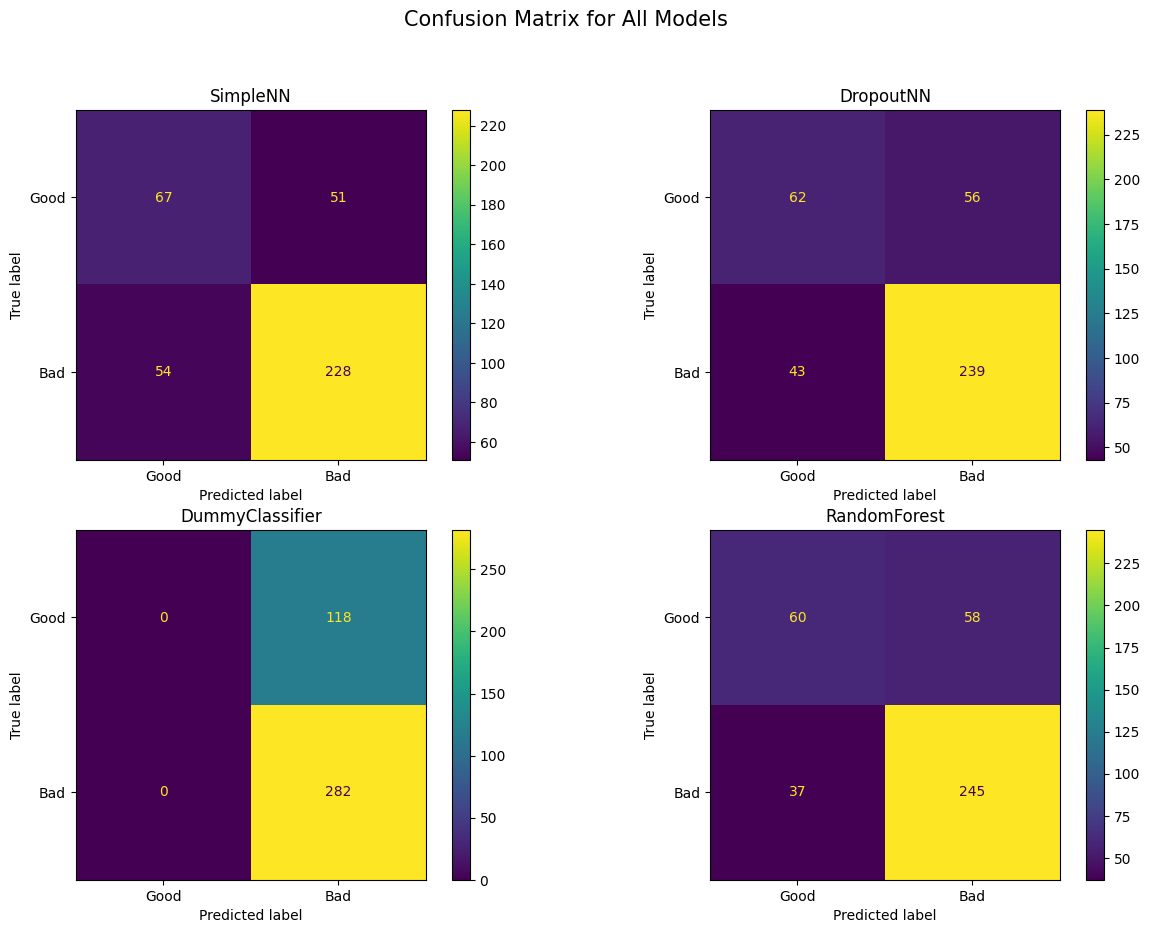

In [617]:
# Assuming df_results contains the evaluation results including confusion matrices
plot_confusion_matrices(df_results)

## Task 7 – Conclusions and Future Work

    No interpretation/reson why someone get the credit or not. further work use lime. 

**Note**: This experiment was created with the help of ChatGPT and the GitHub Copilot.